## Access Mooring Ctd Delayed QC (Parquet)

This Jupyter notebook demonstrates how to access and plot mooring ctd delayed qc data, available as a [Parquet](https://parquet.apache.org) dataset stored on S3.

🔗 More information about the dataset is available [in the AODN metadata catalogue](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/7b901002-b1dc-46c3-89f2-b4951cedca48).

📌 The source of truth for this notebook is maintained on [GitHub](https://github.com/aodn/aodn_cloud_optimised/tree/main/notebooks/mooring_ctd_delayed_qc.ipynb).


In [1]:
dataset_name = "mooring_ctd_delayed_qc"

## Install/Update packages and Load common functions

In [2]:
import os, requests, importlib.util

open('setup.py', 'w').write(requests.get('https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/setup.py').text)

spec = importlib.util.spec_from_file_location("setup", "setup.py")
setup = importlib.util.module_from_spec(spec)
spec.loader.exec_module(setup)

setup.install_requirements()
setup.load_dataquery()

Using CPython 3.12.6 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Audited 240 packages in 63ms


✅ Local version 0.2.1 is up to date (remote: 0.2.1)


In [3]:
from DataQuery import GetAodn

# Understanding the Dataset

## Understanding Parquet Partitioning

Parquet files can be **partitioned** by one or more columns, which means the data is physically organised into folders based on the values in those columns. This is similar to how databases use indexes to optimise query performance.

Partitioning enables **faster filtering**: when you query data using a partitioned column, only the relevant subset of files needs to be read—improving performance significantly.

For example, if a dataset is partitioned by `"site_code"`, `"timestamp"`, and `"polygon"`, filtering on `"site_code"` allows the system to skip unrelated files entirely.

In this notebook, the `GetAodn` class includes built-in methods to efficiently filter data by **time** and **latitude/longitude** using the **timestamp** and **polygon** partitions. Other partitions can be used for filtering via the `scalar_filter`.

Any filtering on columns that are **not** partitioned can be significantly slower, as all files may need to be scanned. However, the `GetAodn` class provides a `scalar_filter` method that lets you apply these filters at load time—before the data is fully read—helping reduce the size of the resulting DataFrame.

Once the dataset is loaded, further filtering using Pandas is efficient and flexible.

See further below in the notebook for examples of how to filter the data effectively.

To view the actual partition columns for this dataset, run:


In [4]:
aodn = GetAodn()
dname = f'{dataset_name}.parquet'
%time aodn_dataset = aodn.get_dataset(dname)

CPU times: user 132 ms, sys: 30.2 ms, total: 162 ms
Wall time: 6.95 s


In [5]:
aodn_dataset.dataset.partitioning.schema

site_code: string
timestamp: int32
polygon: string

## List unique partition values

In [6]:
%%time
unique_partition_value = aodn_dataset.get_unique_partition_values('site_code')
print(list(unique_partition_value)[0:10])  # showing a subset only

['GBRHIS', 'NWSROW', 'SAM7DS', 'SAM5CB', 'ITFMHB', 'SAM1DS', 'SAMUSG', 'SYD140', 'KIM400', 'CAM100']
CPU times: user 25.5 ms, sys: 10.7 ms, total: 36.1 ms
Wall time: 25.2 ms


## Visualise Spatial Extent of the dataset
This section plots the polygons representing the areas where data is available. It helps to identify and create a bounding box around the regions containing data.

/home/lbesnard/miniforge3/envs/AodnCloudOptimised/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


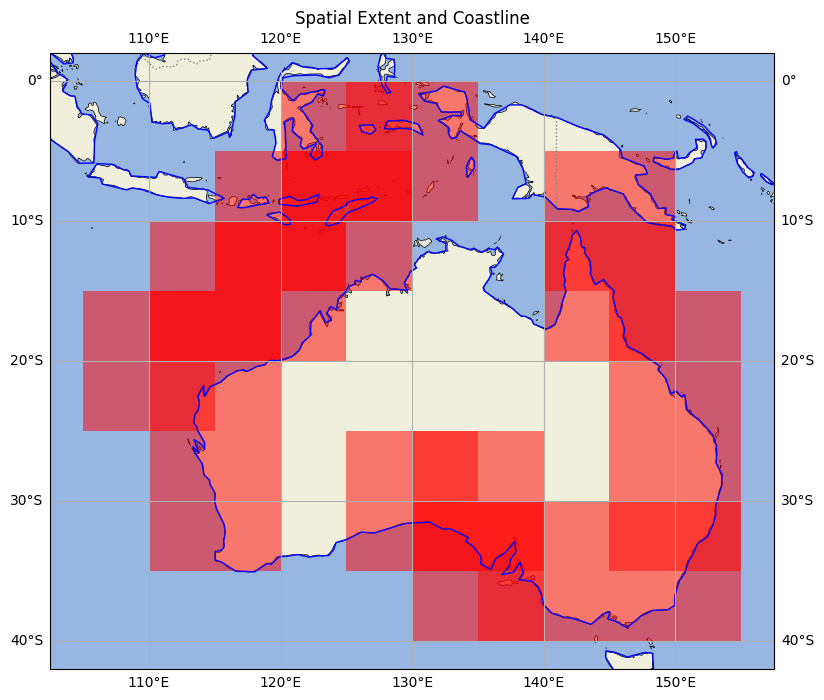

In [7]:
aodn_dataset.plot_spatial_extent()

## Get Temporal Extent of the dataset
Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset.

## Get partition keys
Partitioning in Parquet involves organising data files based on the values of one or more columns, known as partition keys. When data is written to Parquet files with partitioning enabled, the files are physically stored in a directory structure that reflects the partition keys. This directory structure makes it easier to retrieve and process specific subsets of data based on the partition keys.

In [8]:
aodn_dataset.get_temporal_extent()

(Timestamp('2008-05-04 23:00:00.999997952'),
 Timestamp('2024-07-15 06:30:00.999997952'))

## Read Metadata

For all Parquet datasets, we create a sidecar file named **_common_metadata** in the root of the dataset. This file contains both the dataset-level and variable-level attributes.  
The metadata can be retrieved below as a dictionary, and it will also be included in the pandas DataFrame when using the `get_data` method from the `GetAodn` class.

In [9]:
metadata = aodn_dataset.get_metadata()
metadata

2025-06-05 13:09:56,880 - aodn.GetAodn - INFO - Retrieving metadata for aodn-cloud-optimised/mooring_ctd_delayed_qc.parquet
2025-06-05 13:09:56,996 - aodn.GetAodn - WARNING - Old 'dataset_medata' deprecated key found in parquet schema. Renamed to 'global_attributes'. Dataset should be updated


{'TIME': {'type': 'timestamp[ns]',
  'axis': 'T',
  'comment': 'timeOffsetPP: TIME values and time_coverage_start/end global attributes have been applied the following offset : -10 hours.',
  'long_name': 'time',
  'standard_name': 'time',
  'valid_max': 90000.0,
  'valid_min': 0.0},
 'TIMESERIES': {'type': 'int32',
  'cf_role': 'timeseries_id',
  'long_name': 'unique_identifier_for_each_timeseries_feature_instance_in_this_file'},
 'LATITUDE': {'type': 'double',
  'axis': 'Y',
  'long_name': 'latitude',
  'reference_datum': 'WGS84 geographic coordinate system',
  'standard_name': 'latitude',
  'units': 'degrees_north',
  'valid_max': 90.0,
  'valid_min': -90.0},
 'LONGITUDE': {'type': 'double',
  'axis': 'X',
  'long_name': 'longitude',
  'reference_datum': 'WGS84 geographic coordinate system',
  'standard_name': 'longitude',
  'units': 'degrees_east',
  'valid_max': 180.0,
  'valid_min': -180.0},
 'NOMINAL_DEPTH': {'type': 'float',
  'axis': 'Z',
  'long_name': 'nominal depth',
  'pos

# Data Query and Plot

## Create a TIME and BoundingBox filter

This cell loads a subset of the dataset based on a time range and a spatial bounding box. The result is returned as a pandas DataFrame, and basic information about its structure is displayed.

In [10]:
%%time
df = aodn_dataset.get_data(date_start='2022-12-05', date_end='2022-12-15', lat_min=-34, lat_max=-28, lon_min=151, lon_max=160)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23040 entries, 0 to 23039
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   TIME                      23040 non-null  datetime64[ns]
 1   TIMESERIES                23040 non-null  int32         
 2   LATITUDE                  23040 non-null  float64       
 3   LONGITUDE                 23040 non-null  float64       
 4   NOMINAL_DEPTH             23040 non-null  float32       
 5   CNDC                      23040 non-null  float32       
 6   CNDC_quality_control      23040 non-null  float32       
 7   TEMP                      23040 non-null  float32       
 8   TEMP_quality_control      23040 non-null  float32       
 9   PSAL                      23040 non-null  float32       
 10  PSAL_quality_control      23040 non-null  float32       
 11  PRES_REL                  23040 non-null  float32       
 12  PRES_REL_quality_c

In [ ]:
## Download Subsetted Data as CSV

# This cell downloads the filtered dataset as a ZIP-compressed CSV file.  
# The CSV includes metadata at the top as commented lines, and a `FileLink` object is returned to allow downloading directly from the notebook.


df.aodn.download_as_csv()

## Create a TIME and scalar/number filter

This cell filters the dataset by time range and a scalar value (from a Parquet partition) using the `scalar_filter` argument.  
This leverages Parquet partitioning to apply efficient, server-side filtering, which significantly speeds up data loading.

In [11]:
%%time
df = aodn_dataset.get_data(date_start='2022-12-05', date_end='2022-12-15', lat_min=-34, lat_max=-28, lon_min=151, lon_max=160, scalar_filter={'site_code': 'CH100'})
df.info()
df['site_code'] = df['site_code'].astype('category')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5760 entries, 0 to 5759
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   TIME                      5760 non-null   datetime64[ns]
 1   TIMESERIES                5760 non-null   int32         
 2   LATITUDE                  5760 non-null   float64       
 3   LONGITUDE                 5760 non-null   float64       
 4   NOMINAL_DEPTH             5760 non-null   float32       
 5   CNDC                      5760 non-null   float32       
 6   CNDC_quality_control      5760 non-null   float32       
 7   TEMP                      5760 non-null   float32       
 8   TEMP_quality_control      5760 non-null   float32       
 9   PSAL                      5760 non-null   float32       
 10  PSAL_quality_control      5760 non-null   float32       
 11  PRES_REL                  5760 non-null   float32       
 12  PRES_REL_quality_con

In [12]:
df[df['NOMINAL_DEPTH'] == 9]['site_code'].unique()

['CH100']
Categories (1, object): ['CH100']

<Axes: title={'center': 'Temperature for each location'}, xlabel='sea_water_temperature', ylabel='sea_water_practical_salinity'>

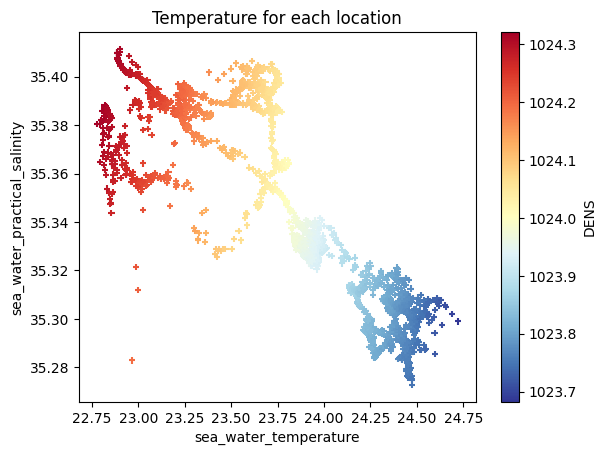

In [13]:
df[(df['NOMINAL_DEPTH'] == 9) & (df['site_code']=='CH100')].plot.scatter(x='TEMP', y='PSAL', 
                                                                         c='DENS', marker='+', linestyle="None", cmap='RdYlBu_r', 
                                                                         title='Temperature for each location',
                                                                         ylabel=metadata['PSAL']['standard_name'],
                                                                         xlabel=metadata['TEMP']['standard_name'])

<Axes: xlabel='TIME', ylabel='sea_water_temperature'>

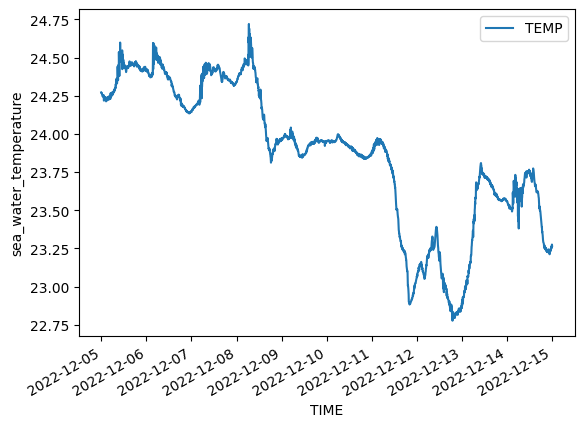

In [14]:
df[(df['NOMINAL_DEPTH'] == 9) & (df['site_code']=='CH100')].sort_values('TIME').plot(y='TEMP', x='TIME',
                                                                                     ylabel=metadata['TEMP']['standard_name'])

## Plot TS diagram - compare with quality control values

### Example A

<Axes: title={'center': 'Temperature for each location'}, xlabel='sea_water_temperature', ylabel='sea_water_practical_salinity'>

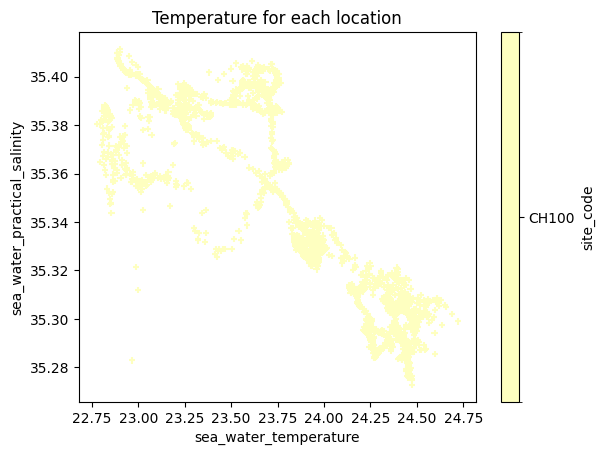

In [15]:
df[(df['NOMINAL_DEPTH'] <= 20) ].plot.scatter(x='TEMP', y='PSAL', c='site_code', 
                                              marker='+', linestyle="None", cmap='RdYlBu_r', 
                                              title='Temperature for each location',
                                              ylabel=metadata['PSAL']['standard_name'],
                                              xlabel=metadata['TEMP']['standard_name'])

<Axes: title={'center': 'Temperature for each location'}, xlabel='sea_water_temperature', ylabel='sea_water_practical_salinity'>

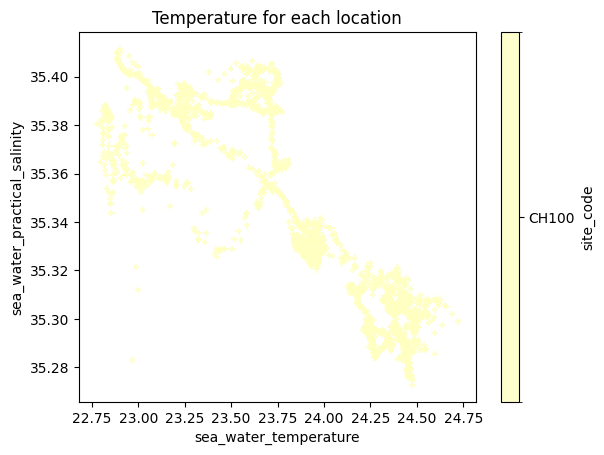

In [16]:
df[(df['NOMINAL_DEPTH'] <= 20) & (df['PSAL_quality_control'] == 1) ].plot.scatter(x='TEMP', y='PSAL', c='site_code', 
                                                                                  marker='+', linestyle="None", cmap='RdYlBu_r', 
                                                                                  alpha=0.8, title='Temperature for each location',
                                                                                  ylabel=metadata['PSAL']['standard_name'],
                                                                                  xlabel=metadata['TEMP']['standard_name'])

## Example B

<Axes: title={'center': 'TS at CH100 at various nominal depths'}, xlabel='sea_water_temperature', ylabel='sea_water_practical_salinity'>

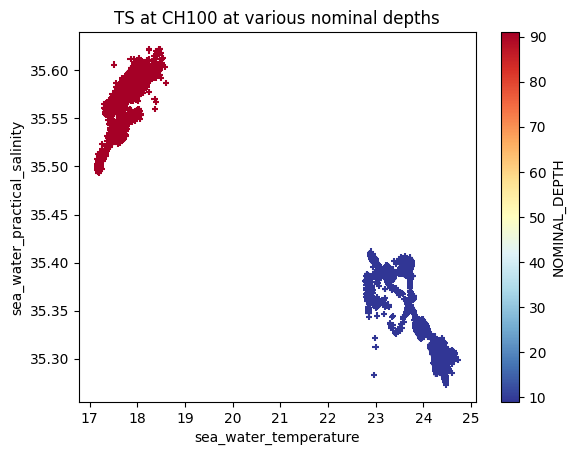

In [17]:
df[(df['site_code']=='CH100')].plot.scatter(x='TEMP', y='PSAL', c='NOMINAL_DEPTH', 
                                            marker='+', linestyle="None", cmap='RdYlBu_r', 
                                            title='TS at CH100 at various nominal depths',
                                              ylabel=metadata['PSAL']['standard_name'],
                                              xlabel=metadata['TEMP']['standard_name'])

<Axes: title={'center': 'TS at CH100 at various nominal depths'}, xlabel='sea_water_temperature', ylabel='sea_water_practical_salinity'>

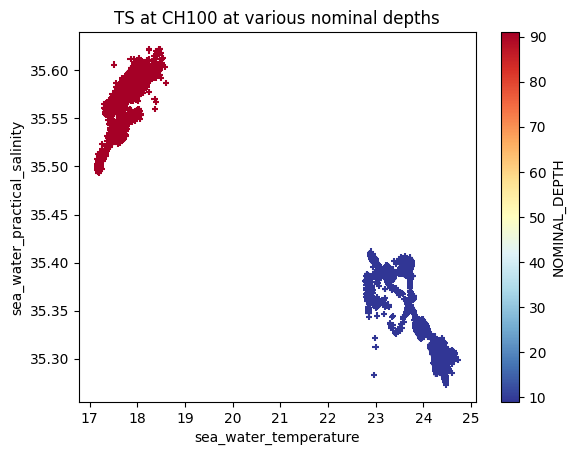

In [18]:
df[(df['site_code']=='CH100') & (df['PSAL_quality_control'] == 1)].plot.scatter(x='TEMP', y='PSAL', 
                                                                                c='NOMINAL_DEPTH', marker='+', linestyle="None", 
                                                                                cmap='RdYlBu_r', 
                                                                                title='TS at CH100 at various nominal depths',
                                                                                ylabel=metadata['PSAL']['standard_name'],
                                                                                xlabel=metadata['TEMP']['standard_name'])